In [15]:
%conda install pytorch torchvision -c pytorch
%conda install -c fastai fastai

Solving environment: done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.
Solving environment: done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [16]:
from fastai.vision.all import *
from fastcore.all import *

## Cat v dog single-label classification example

### Label dataset

In [ ]:
path = untar_data(URLs.PETS)
file_names = get_image_files(path/'images')

def label_func(filename):
    return "cat" if filename.name[0].isupper() else "dog"

dblock = DataBlock(blocks    = (ImageBlock, CategoryBlock),
                   get_items = get_image_files,
                   get_y     = label_func,
                   splitter  = RandomSplitter(),
                   item_tfms = Resize(224))

dls = dblock.dataloaders(path/"images")
dls.show_batch()

### Retraining ResNet34 on new labeled dataset

In [ ]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(1)

### Test the performance of retrained model

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(6,6))
interp.plot_top_losses(9, figsize=(15,10))

In [ ]:
img = PILImage.create(file_names[9])

prediction,_,probs = learn.predict(img)

print(f"Predicted animal: {prediction}.")
print(f"Probability it is this animal: {probs[1].item():.6f}")
img.to_thumb(192)

## Retrain for single-label Chest cancer classification

### Label and load images into datablock

In [17]:
path = 'data'
dls = ImageDataLoaders.from_folder(path,
                            train = 'train',
                            valid = 'valid',
                            test = 'test',
                            item_tfms = Resize(224)) # imagenet models often use 224 x 224. Our images aren't 1:1 aspect ratio, by default center crop will be used. We can add pad_mode='zeros' for no cropping.

### Test the accuracy of stock imagenet model

In [ ]:
# TODO: IN PROGRESS

# model = resnet34(pretrained = True)

# # switch to evaluation mode for inference rather than training
# model.eval()

### Retrain model on new data set

In [31]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(1)

epoch,train_loss,valid_loss,error_rate,time
0,1.809031,1.017298,0.444444,00:01


epoch,train_loss,valid_loss,error_rate,time


### Test the accuracy of retrained model

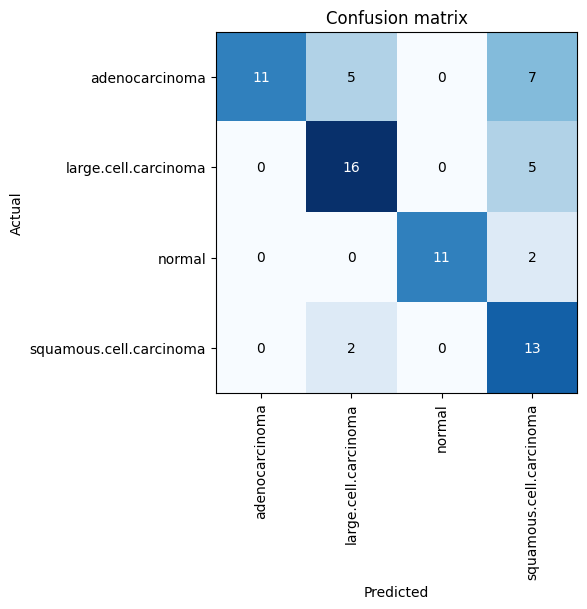

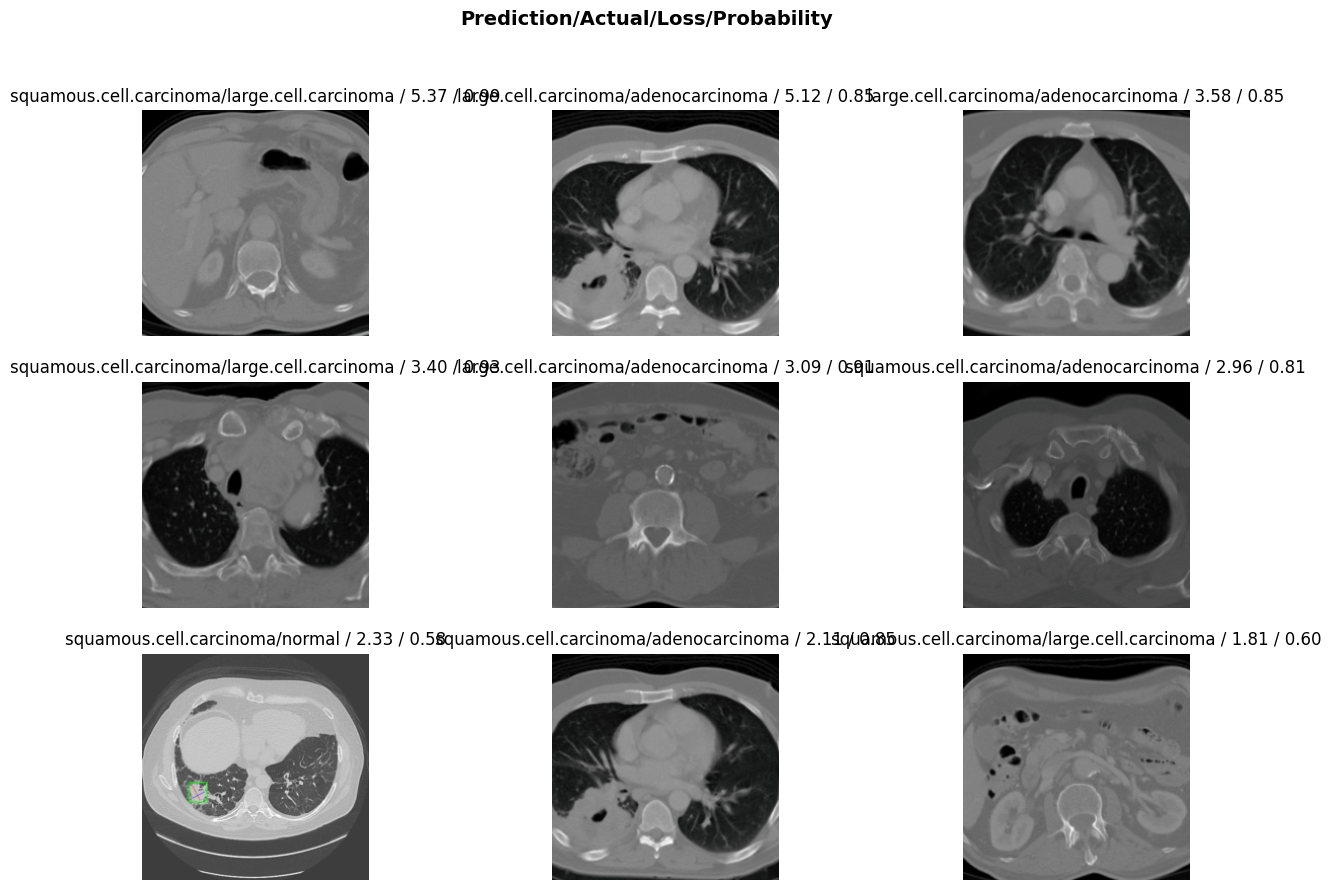

In [19]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(6,6))
interp.plot_top_losses(9, figsize=(15,10))

Predicted picture: large.cell.carcinoma.
Probability: 0.955889


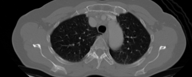

In [29]:
file_names = get_image_files(path)
img = PILImage.create(file_names[random.randint(0, len(file_names)) - 1])

prediction,_,probs = learn.predict(img)

print(f"Predicted picture: {prediction}.")
print(f"Probability: {probs[1].item():.6f}")
img.to_thumb(192)